# FIL24

## Init

In [11]:
import classifim.bench.fidelity
import classifim.bench.metric
import classifim.bench.plot_tools
import classifim.utils
import classifim_gen.fil24_hamiltonian
import classifim_gen.gs_cache
import classifim_gen.gs_utils
import classifim_gen.hubbard_hamiltonian
import classifim_gen.io
import concurrent.futures
import functools
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import scipy.sparse.linalg
import sys
from tqdm import tqdm

The following settings were used to generate the images for the main paper. They are commented out (the cell is made "raw" using CTRL+R, use CTRL+Y to make it "code") since they require a LaTeX installation with some fonts and packages used by matplotlib.

In [2]:
# [Optional]: matplotlib.backend_bases.register_backend('pgf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
SM_NAME = "fil_24"
DATA_DIR0 = classifim.utils.find_data_dir()
assert os.path.isdir(DATA_DIR0)
DATA_DIR = classifim.utils.maybe_create_subdir(DATA_DIR0, SM_NAME)

HF_DATA_DIR0 = classifim.utils.find_data_dir("hf_data_dir")
HF_DATA_DIR = classifim.utils.maybe_create_subdir(HF_DATA_DIR0, SM_NAME)

In [4]:
ham_family = classifim_gen.fil24_hamiltonian.CppFil1DFamily(
    nsites=12, edge_dirs=[1, 3, 9, 11])
param_conversions = classifim_gen.fil24_hamiltonian.Fil24ParamConversions()

In [5]:
@functools.cache
def get_lanczos_cache():
    """
    Returns lanczos_cache without a way to compute new values.
    """
    DATA_LANCZOS_DIR = os.path.join(DATA_DIR, "lanczos")
    assert os.path.exists(DATA_LANCZOS_DIR)
    return classifim_gen.gs_cache.GroundStateCache(
        compute_ground_state=None,
        param_keys=ham_family.PARAM_NAMES,
        ham_name=SM_NAME.lower(),
        save_path=DATA_LANCZOS_DIR,
        load_meta=True,
        filename_source=classifim_gen.gs_cache.FS_FILESYSTEM)

In binary notation $\uparrow$ is $0$ and $\downarrow$ is $1$, in $Z$ notation $\uparrow$ is $1$ and $\downarrow$ is $-1$. Dimensionality reduction is from $2^{24}$ to $704370$:

In [6]:
len(ham_family.vi_to_z)

704370

## Data generation

### Lanczos

* Requires: nothing
* Generates: ground state vectors and probabilities in lanczos dir (but takes weeks to do so, use HPC instead)

In [5]:
def compute_lanczos_f(ncv, maxiter):
    def compute_lanczos(params_vec):
        return classifim_gen.gs_utils.compute_lanczos(
            params_vec,
            ham_family=ham_family,
            k=4,
            ncv=ncv,
            maxiter=maxiter,
            beta=1.0e7,
            payload=None,
            verbose=False
        )
    return compute_lanczos
resolution = 64
lambdas = np.array([(lambdai0 / resolution, lambdai1 / resolution) for lambdai0 in range(resolution) for lambdai1 in range(resolution)])
param_vecs = np.array(param_conversions.lambdas_to_params(*lambdas.T)).T
DATA_LANCZOS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "lanczos")
lanczos_cache = classifim.bench.GroundStateCache(
    # ncv and maxiter need to be increased for some points.
    compute_ground_state=compute_lanczos_f(40, 40),
    param_keys=ham_family.PARAM_NAMES,
    ham_name=SM_NAME.lower(),
    save_path=DATA_LANCZOS_DIR,
    load_meta=True,
    filename_source=classifim_gen.gs_cache.FS_FILESYSTEM
)

In [ ]:
# This should compute "ground state" for all values of parameters in theory.
# Takes weeks in practice.
LOCK_FILE_PATH = os.path.join(DATA_LANCZOS_DIR, f"{SM_NAME.lower()}_bench.lock")
num_success = 0
num_error = 0
num_skipped = 0
done = False
with classifim_gen.gs_utils.ProcessLockFile(LOCK_FILE_PATH) as process_lock:
    print(f"Locked using '{LOCK_FILE_PATH}'. Remove to stop softly.")
    try:
        for ncv in (40, 60, 90, 130, 200):
            if done or num_success + num_skipped >= param_vecs.shape[0]:
                break
            num_success = 0
            num_error = 0
            num_skipped = 0
            # Use maxiter = ncv. This can be optimized further.
            lanczos_cache.compute_ground_state = compute_lanczos_f(ncv, maxiter=ncv)
            progress_printer = classifim.bench.ProgressPrinter()
            progress_printer.pprintln(f"Start time: {progress_printer.get_now_str()}")
            for param_vec in param_vecs:
                if not process_lock.exists():
                    progress_printer.pprintln(f"\rLock file '{LOCK_FILE_PATH}' removed; exiting.")
                    done = True
                    break
                try:
                    res = lanczos_cache.get_ground_state(tuple(param_vec), load=False)
                except classifim_gen.gs_cache.GroundStateComputationError:
                    res = 'error'
                if res is None:
                    num_skipped += 1
                    progress_printer.inc_i(char='.')
                elif res == 'error':
                    num_error += 1
                    progress_printer.inc_i(char='E')
                else:
                    num_success += 1
                    progress_printer.inc_i(char='S')
            progress_printer.pprintln(f"\r{ncv=} done: {num_success=} {num_error=} {num_skipped=}")
    finally:
        lanczos_cache.save_meta()
        progress_printer.pprintln(f"\rEnd time: {progress_printer.get_now_str()}")

### Generate datasets

* Requires: ground state probabilities in "lanczos" directory.
* Generates: classifim_datasets

In [6]:
%%time
BITCHIFC_DATASET_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "classifim_datasets")
lanczos_cache = get_lanczos_cache()
resolution = 64
lambdas = np.array([
    (lambda0, lambda1)
    for lambda0 in np.arange(resolution) / resolution
    for lambda1 in np.arange(resolution) / resolution])
params_vecs = np.array(param_conversions.lambdas_to_params(*lambdas.T)).T
print(f"{params_vecs.shape=}")
datasets = classifim_gen.gs_utils.generate_datasets(
    gs_cache=lanczos_cache,
    lambdas=lambdas,
    params_vecs=params_vecs,
    vi_to_z=ham_family.vi_to_z,
    seeds=(41,))
    # seeds=range(42, 52))

for dataset in datasets:
    seed = dataset["seed"]
    dataset["zs"] = ham_family.randomly_transform_z(dataset["zs"], seed=seed + 1)
    dataset["zs"] = ham_family.repack_z_for_bschifc(dataset["zs"])
    dataset_file_name = os.path.join(BITCHIFC_DATASET_DIR, f"dataset_{seed}.npz")
    np.savez_compressed(dataset_file_name, **dataset)
    print(f"Dataset is saved to '{dataset_file_name}'")

params_vecs.shape=(4096, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [11:52<00:00,  5.75it/s]


Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/classifim_datasets/dataset_41.npz'
CPU times: user 5min 42s, sys: 17.4 s, total: 6min
Wall time: 11min 52s


### Convert to parquet

In [9]:
importlib.reload(classifim_gen.io)
importlib.reload(classifim_gen.hubbard_hamiltonian)
data_seeds = classifim_gen.io.save_datasets_for_hf(
    convert_f=classifim_gen.hubbard_hamiltonian.convert_dataset_to_hf,
    input_pattern=os.path.join(DATA_DIR, "classifim_datasets", "dataset_{seed}.npz"),
    output_dir=HF_DATA_DIR,
    overwrite=True)
print("Done.")

Done.


In [12]:
with np.load(os.path.join(DATA_DIR, "fim", "gs_fim.npz")) as f:
    fim_npz = dict(f)
gt_fim_filename = os.path.join(HF_DATA_DIR, "gt_fim.parquet")
pq.write_table(pa.Table.from_pydict(fim_npz), gt_fim_filename)

In [13]:
import importlib
importlib.reload(classifim_gen.io)
print(classifim_gen.io.gen_config_yml(
    sm_name=os.path.basename(HF_DATA_DIR),
    seeds=sorted(data_seeds),
    fim_seeds=None))

- config_name: fil_24.gt_fim
  data_files:
  - split: test
    path: fil_24/gt_fim.parquet
- config_name: fil_24.seed41
  data_files:
  - split: train
    path: fil_24/seed_41/d_train.parquet
  - split: test
    path: fil_24/seed_41/d_test.parquet
- config_name: fil_24.seed42
  data_files:
  - split: train
    path: fil_24/seed_42/d_train.parquet
  - split: test
    path: fil_24/seed_42/d_test.parquet
- config_name: fil_24.seed43
  data_files:
  - split: train
    path: fil_24/seed_43/d_train.parquet
  - split: test
    path: fil_24/seed_43/d_test.parquet
- config_name: fil_24.seed44
  data_files:
  - split: train
    path: fil_24/seed_44/d_train.parquet
  - split: test
    path: fil_24/seed_44/d_test.parquet
- config_name: fil_24.seed45
  data_files:
  - split: train
    path: fil_24/seed_45/d_train.parquet
  - split: test
    path: fil_24/seed_45/d_test.parquet
- config_name: fil_24.seed46
  data_files:
  - split: train
    path: fil_24/seed_46/d_train.parquet
  - split: test
    pat

## Benchmarking

### Compute ground truth FIM

* Requires: ground state probabilities in "lanczos" directory.
* Generates: ground truth ChiFc (`fim/gs_fim.npz`)

In [7]:
%%time
FIM_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "fim")
lanczos_cache = get_lanczos_cache()

gs_fim = classifim.bench.fidelity.compute_2d_fim(
    param_conversions.lambdas_to_params, lanczos_cache,
    resolution=64, verbose=True)

gs_fim_npz = {}
for key, value in gs_fim.items():
    np_value = value.to_numpy()
    if np_value.dtype == object:
        np_value = np_value.astype(bytes)
    gs_fim_npz[key] = np_value

file_name = os.path.join(FIM_DIR, "gs_fim.npz")
np.savez_compressed(
    file_name,
    **gs_fim_npz)
print(f"gs_fim saved to '{file_name}'")

  0%|                                                                                                                                                  | 0/16384 [00:00<?, ?it/s]

KeyError: 'fim'

### Load FIM

* Requires:
    - ground truth ChiFc (`fim/gs_fim.npz`)
    - estimated ChiFc (`fim/{ml_model_name}*.npz`)
* Loads ChiFc into global variables `gs_fim`, `gs_fim_mgrid`, `ML_NAME`, `ml_fims`, `ml_fim_mgrids`.

In [10]:
FIM_DIR = os.path.join(DATA_DIR, "fim")

In [11]:
# Load ground truth FIM:
gs_fim_filename = os.path.join(FIM_DIR, "gs_fim.npz")
gs_fim = classifim.bench.fidelity.as_data_frame(np.load(gs_fim_filename), decode=True)
gs_fim_mgrid = classifim.bench.fidelity.meshgrid_transform_2D_fim(gs_fim)

In [12]:
# Load estimated FIM:
ML_NAME = "9_reshuffle"
ML_FIM_PATH = os.path.join(FIM_DIR, f"{ML_NAME}_" + "{seed}.npz")
ml_fims = {}
ml_fim_mgrids = {}
for ml_fim_seed in range(41, 52): # TODO:9: change back to range(42, 52)
    ml_fim_npz = np.load(ML_FIM_PATH.format(seed=ml_fim_seed))
    ml_fim = classifim.bench.fidelity.as_data_frame(ml_fim_npz)
    ml_fims[ml_fim_seed] = ml_fim
    ml_fim_mgrids[ml_fim_seed] = classifim.bench.plot_tools.df_to_meshgrid(
        ml_fim, x_col='lambda0', y_col='lambda1')

### 1D "phase" diagrams

* Requires:
    - Run "Load ChiFc" section above
* Produces 1D plots of ground truth and predicted fidelity susceptibility.

Saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/figs/chifc_9_reshuffle_lambda1_12b-6_thin.png'


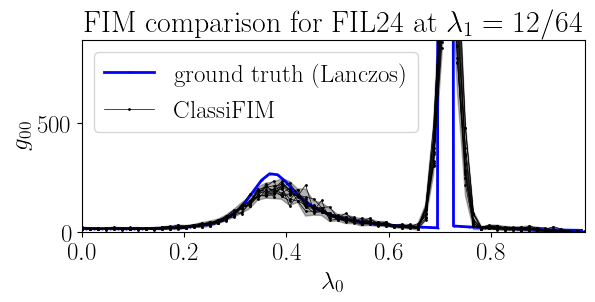

In [39]:
font = {'family' : 'serif', 'weight' : 'bold', 'size'   : 18}
matplotlib.rc('font', **font)

FIG_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
file_name = os.path.join(FIG_DIR, f"chifc_{ML_NAME}_" + "lambda{fixed_lambda_index}_{fixed_lambda_int_val}b-6_thin.png")
classifim.bench.plot_tools.plot_fim_df_1d(
    gs_chifc,
    list(ml_chifcs.values()),
    fixed_lambda=(1, 12),
    ymax=880,
    sm_name="FIL24",
    file_name=file_name,
    figsize=(6.5,2.5),
    savefig_kwargs={"dpi": 300},
    verbose=True # Change to True to print the file name
)

### 2D "phase" diagrams

* Requires:
    - Run "Load ChiFc" section above
* Produces 2D plots of ground truth and predicted fidelity susceptibility.

Saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/figs/phase_42.png'.


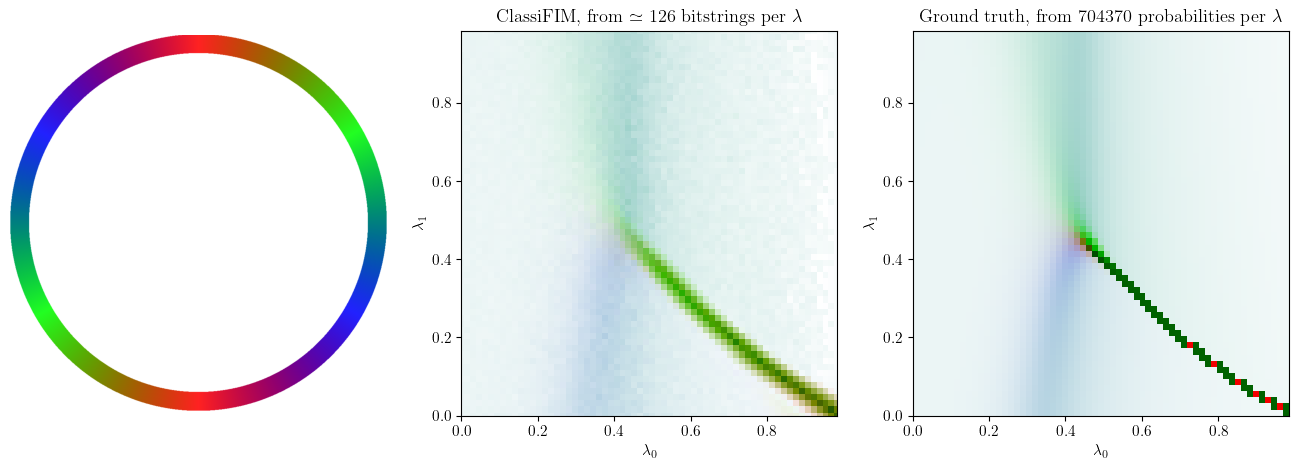

In [34]:
FIG_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
ml_chifc_seed = 42
res = plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(ncols=3, figsize=(3 * 5.5, 5))
(ax0, ax1, ax2) = axs

classifim.bench.plot_tools.plot_fim_mgrid_legend(ax0, r0=0)

zz_max = 54
classifim.bench.plot_tools.plot_fim_mgrid(ax1, ml_chifc_mgrids[ml_chifc_seed], zz_max=zz_max)
ax1.set_title("ClassiFIM, from $\simeq 126$ bitstrings per $\mathbf{\lambda}$")

classifim.bench.plot_tools.plot_fim_mgrid(ax2, gs_chifc_mgrid, zz_max=zz_max)
ax2.set_title("Ground truth, from 704370 probabilities per $\mathbf{\lambda}$")

file_name = os.path.join(FIG_DIR, f"phase_{ml_chifc_seed}.png")
fig.savefig(file_name, bbox_inches='tight')
print(f"Saved to '{file_name}'.")

### Test error

0.2422 \pm 0.0008


### Compute dist metrics

* Requires:
    - Run "Load FIM" section above
* Produces: `metrics/dist_res.npz` with distSE values, distMSE & distRE metrics

In [13]:
METRICS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "metrics")

In [23]:
%%time
res = {}
def wrapper(ml_fim_seed):
    prng = classifim.utils.DeterministicPrng(ml_fim_seed)
    cur_res = classifim.bench.metric.compute_distance_errors(
        ml_fim_mgrids[ml_fim_seed], gs_fim_mgrid, num_pairs=8386560,
        seed=prng.get_seed("compute_distance_errors"),
        use_cpp=True)
    res[ml_fim_seed] = cur_res
    return ml_fim_seed
with concurrent.futures.ThreadPoolExecutor() as executor:
    r = list(executor.map(wrapper, range(42, 52)))

CPU times: user 2h 13min 14s, sys: 1min 53s, total: 2h 15min 7s
Wall time: 1h 40min 55s


In [24]:
dist_res = {}
for key in next(iter(res.values())).keys():
    value = np.array([r[key] for r in res.values()])
    dist_res[key] = value
dist_res["ml_chifc_seed"] = np.array(list(res.keys()))
DIST_RES_PATH = os.path.join(METRICS_DIR, "dist_res.npz")
np.savez_compressed(DIST_RES_PATH, **dist_res)

### Print dist metrics

In [24]:
# TODO:6: delete this cell (keep the one below with dist_res.npz instead)
METRICS_DIR = os.path.join(DATA_DIR, "metrics")
for version in ("_tmp", "_tmp2", "_tmp3", "_tmp4"):
    dist_res_filename = os.path.join(METRICS_DIR, f"dist_res{version}.npz")
    dist_res = np.load(dist_res_filename)
    df = {key: value for key, value in dist_res.items() if len(value.shape) == 1}
    df = pd.DataFrame(df)
    df.set_index("ml_chifc_seed", inplace=True)

    display(df)

,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,scale
ml_chifc_seed,,,,,,,,
41,5120,0.123124,0.043975,1.039071,0.251863,0.0,0.07487,1.112497


,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,scale
ml_chifc_seed,,,,,,,,
41,287075,0.114975,0.043815,1.054441,0.255866,0.0,0.069347,1.110588


,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,scale
ml_chifc_seed,,,,,,,,
41,287075,0.493827,0.110514,1.054441,0.255866,0.0,0.278476,1.284387


,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,scale
ml_chifc_seed,,,,,,,,
41,287075,0.114975,0.043815,1.054441,0.255866,0.0,0.069347,1.110588


In [16]:
with np.load(dist_res_filename) as f:
    print(list(f.keys()))

['num_pairs', 'lambda_pairs', 'distances', 'distMSE', 'distRE', 'distMSE_const', 'distRE_const', 'distRE_perfect', 'distMSE_perfect_scale', 'scale', 'ml_chifc_seed']


In [17]:
METRICS_DIR = os.path.join(DATA_DIR, "metrics")
dist_res_filename = os.path.join(METRICS_DIR, "dist_res.npz")
with np.load(dist_res_filename) as f:
    df = pd.DataFrame({
        key: value
        for key in f.keys()
        if key not in ["lambda_pairs", "distances"]
            and len((value := f[key]).shape) == 1
    })
df.set_index("ml_chifc_seed", inplace=True)

display(df)

for column_name, values in df.items():
    digits = 4
    if 'distRE' in column_name:
        digits = 2
        values = values * 100
        column_name = column_name + " (%)"
    elif column_name.startswith("num_"):
        digits = 0
    print(f"{column_name}: ${classifim.bench.metric.normal_summary(values, digits=digits)}$")

,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,scale
ml_chifc_seed,,,,,,,,
43,8386560,0.457575,0.042942,4.207848,0.255958,8.815035e-13,0.279303,1.109370
48,8386560,0.469291,0.043967,4.207848,0.255958,8.815035e-13,0.289217,1.110015
47,8386560,0.424193,0.041681,4.207848,0.255958,8.815035e-13,0.268281,1.101527
45,8386560,0.458561,0.043924,4.207848,0.255958,8.815035e-13,0.272671,1.111918
51,8386560,0.478792,0.043647,4.207848,0.255958,8.815035e-13,0.270840,1.119136
46,8386560,0.549583,0.047364,4.207848,0.255958,8.815035e-13,0.306244,1.130285
50,8386560,0.487333,0.044026,4.207848,0.255958,8.815035e-13,0.292032,1.115106
49,8386560,0.435056,0.042871,4.207848,0.255958,8.815035e-13,0.268489,1.105299
42,8386560,0.460136,0.043637,4.207848,0.255958,8.815035e-13,0.277793,1.110744


num_pairs: $8386560 \pm 0$
distMSE: $0.4684 \pm 0.0323$
distRE (%): $4.39 \pm 0.14$
distMSE_const: $4.2078 \pm 0.0000$
distRE_const (%): $25.60 \pm 0.00$
distRE_perfect (%): $0.00 \pm 0.00$
distMSE_perfect_scale: $0.2809 \pm 0.0116$
scale: $1.1123 \pm 0.0075$


### Best possible cross entropy error

* Requires:
    - Ground state probabilities in 'lanczos' dir
    - Test dumps (produced by `twelve_sites_classifim.ipynb`) at `classifim_datasets/test_dump_{seed}.npz`.
* Prints out best possible cross entropy error (for an algorithm which knows ground state probabilities).

In [ ]:
%%time
DATASETS_DIR = os.path.join(DATA_DIR, "classifim_datasets")
assert os.path.isdir(DATASETS_DIR)
best_xes = {}
for seed in range(42, 52):
    res = classifim_gen.fil24_hamiltonian.compute_best_possible_xe(
        dump_npz=np.load(os.path.join(DATASETS_DIR, f"test_dump_{seed}.npz")),
        zs_to_vi_f=lambda zs: ham_family.z_to_vi[ham_family.unrepack_z_for_bschifc(zs)],
        lambdas_to_params_f=param_conversions.lambdas_to_params,
        probs_cache=get_lanczos_cache(),
        resolution=64)
    best_xes[seed] = res

In [ ]:
v = np.array(list(best_xes.values()))
summary = classifim.bench.metric.normal_summary(v)
print(f"Best possible XE: {summary}")

## Identifying critical values

Plan:
1. Load the dataset (seed=42).
2. Train two models:
  - input: $(\lambda_0, x)$, output: $\textrm{sign}(\lambda_1 - 31.5/64)$;
  - input: $(\lambda_1, x)$, output: $\textrm{sign}(\lambda_0 - 31.5/64)$.
3. Determine $\lambda_{1,critical}$ as a function of $\lambda_0$
4. Same for ground truth and the original model.
5. Plot.

In [9]:
DATA_DIR0 = classifim.utils.find_data_dir(code_dir=CODE_DIR)
assert os.path.isdir(DATA_DIR0)

In [10]:
DATA_DIR0

'/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023'

# Scratch